<a href="https://colab.research.google.com/github/anirban-space/pybgp-snn-model/blob/main/PyBGPStream_parse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [2]:
print('Installing dependencies...')
!sudo apt-get install build-essential curl zlib1g-dev libbz2-dev libcurl4-openssl-dev librdkafka-dev
!sudo apt-get update
!sudo apt-get install -y libtool automake autoconf pkg-config
!libtoolize --force
!sudo apt-get install libbz2-dev liblzma-dev liblzo2-dev liblz4-dev libzstd-dev

Installing dependencies...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libbz2-dev is already the newest version (1.0.8-5build1).
libbz2-dev set to manually installed.
curl is already the newest version (7.81.0-1ubuntu1.21).
libcurl4-openssl-dev is already the newest version (7.81.0-1ubuntu1.21).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
The following additional packages will be installed:
  librdkafka++1 librdkafka1
The following NEW packages will be installed:
  librdkafka++1 librdkafka-dev librdkafka1
0 upgraded, 3 newly installed, 0 to remove and 72 not upgraded.
Need to get 1,481 kB of archives.
After this operation, 6,303 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 librdkafka1 amd64 1.8.0-1build1 [633 kB]
Get:2 http://archive.ubuntu.com/ubuntu jamm

In [3]:
print('Installing more build dependencies...')
!sudo apt-get update
!sudo apt-get install -y build-essential autoconf automake libtool curl zlib1g-dev libbz2-dev libcurl4-openssl-dev librdkafka-dev liblzma-dev liblzo2-dev liblz4-dev libzstd-dev libpthread-stubs0-dev
print('Build dependencies installation complete.')

Installing more build dependencies...
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cli.github.com/packages stable InRelease                         
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease               
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease     
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                     
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tr

In [4]:
%cd /content/

# Cleanup previous attempts for libbgpstream
!rm -rf *

# Create sources
# !mkdir /content/wandio
# !mkdir /content/libbgp
# !mkdir /content/pybgp

wandio_repo = "https://github.com/LibtraceTeam/wandio/archive/refs/tags/4.2.6-1.tar.gz"
libbgpstream_repo = "https://github.com/CAIDA/libbgpstream/releases/download/v2.3.0/libbgpstream-2.3.0.tar.gz"
pybgpstream_repo = "https://github.com/CAIDA/pybgpstream/releases/download/v2.0.4/pybgpstream-2.0.4.tar.gz"

# Download wandio and pybgpstream tarballs
!curl -LO "$wandio_repo"
!curl -LO "$libbgpstream_repo"
!curl -LO "$pybgpstream_repo"

# Clone bgpstream using git clone --recursive
# !git clone --recursive $libbgpstream_repo /content/libbgp

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16.3M    0 16.3M    0     0  11.4M      0 --:--:--  0:00:01 --:--:-- 20.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.2M  100 11.2M    0     0  21.5M      0 --:--:-- --:--:-- --:--:-- 21.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12987  100 12987    0     0  43641      0 --:--:-- --:--:-- --:--:-- 43641


In [5]:
import os

# Get a list of all .tar.gz files in the current directory
tar_files = [f for f in os.listdir('.') if f.endswith('.tar.gz')]

# Extract each tar.gz file individually
for tar_file in tar_files:
    print(f"Extracting {tar_file}...")
    !tar zxf "{tar_file}"


%ls

Extracting libbgpstream-2.3.0.tar.gz...
Extracting 4.2.6-1.tar.gz...
Extracting pybgpstream-2.0.4.tar.gz...
4.2.6-1.tar.gz       libbgpstream-2.3.0.tar.gz  pybgpstream-2.0.4.tar.gz
libbgpstream-2.3.0/  pybgpstream-2.0.4/         wandio-4.2.6-1/


In [6]:
wandio_bootstrap_text = """#! /bin/sh

set +x
# Prefer aclocal 1.9 if we can find it
(which aclocal &> /dev/null && aclocal -I m4) ||
(which aclocal &>/dev/null && aclocal -I m4) ||
	aclocal  -I m4

# Darwin bizarrely uses glibtoolize
(which libtoolize &>/dev/null && libtoolize --force --copy) ||
	glibtoolize --force --copy

(which autoheader &>/dev/null && autoheader) ||
autoheader

# Prefer automake-1.9 if we can find it
(which automake &>/dev/null && automake --add-missing --copy --foreign) ||
	automake --add-missing --copy --foreign

(which autoconf &>/dev/null && autoconf) ||
autoconf"""

bootstrap_command = f"echo '{wandio_bootstrap_text}' > bootstrap.sh"
print(bootstrap_command)

echo '#! /bin/sh

set +x
# Prefer aclocal 1.9 if we can find it
(which aclocal &> /dev/null && aclocal -I m4) ||
(which aclocal &>/dev/null && aclocal -I m4) ||
	aclocal  -I m4

# Darwin bizarrely uses glibtoolize
(which libtoolize &>/dev/null && libtoolize --force --copy) ||
	glibtoolize --force --copy

(which autoheader &>/dev/null && autoheader) ||
autoheader

# Prefer automake-1.9 if we can find it
(which automake &>/dev/null && automake --add-missing --copy --foreign) ||
	automake --add-missing --copy --foreign

(which autoconf &>/dev/null && autoconf) ||
autoconf' > bootstrap.sh


In [7]:
folder_prefixes = ['wandio', 'libbgpstream','pybgpstream']

# wandio_bootstrap_text = """#! /bin/sh

# set +x
# # Prefer aclocal 1.9 if we can find it
# (which aclocal &> /dev/null && aclocal -I m4) ||
# (which aclocal &>/dev/null && aclocal -I m4) ||
# 	aclocal  -I m4

# # Darwin bizarrely uses glibtoolize
# (which libtoolize &>/dev/null && libtoolize --force --copy) ||
# 	glibtoolize --force --copy

# (which autoheader &>/dev/null && autoheader) ||
# autoheader

# # Prefer automake-1.9 if we can find it
# (which automake &>/dev/null && automake --add-missing --copy --foreign) ||
# 	automake --add-missing --copy --foreign

# (which autoconf &>/dev/null && autoconf) ||
# autoconf"""

# bootstrap_command = f"echo '{wandio_bootstrap_text}' > bootstrap.sh"

# Define a dictionary mapping each prefix to a list of commands to execute within that directory.
prefix_commands = {
    'wandio': [
        bootstrap_command,
        './bootstrap.sh',
        'chmod a+X configure',
        './configure',
        'make',
        'sudo make install',
        'sudo ldconfig'
    ],
    'libbgpstream': [
        './autogen.sh', # Run autogen.sh first to prepare build files, now that it's a git repo
        'chmod a+X configure',
        './configure',
        'make',
        'make check',
        'sudo make install',
        'sudo ldconfig'
    ],
    'pybgpstream': [
        'python setup.py build_ext',
        'python setup.py build',
        'python setup.py install'
    ]
}

print(f"Defined folder prefixes: {folder_prefixes}")
print(f"Defined commands for prefixes: {prefix_commands}")

Defined folder prefixes: ['wandio', 'libbgpstream', 'pybgpstream']
Defined commands for prefixes: {'wandio': ["echo '#! /bin/sh\n\nset +x\n# Prefer aclocal 1.9 if we can find it\n(which aclocal &> /dev/null && aclocal -I m4) ||\n(which aclocal &>/dev/null && aclocal -I m4) ||\n\taclocal  -I m4\n\n# Darwin bizarrely uses glibtoolize\n(which libtoolize &>/dev/null && libtoolize --force --copy) ||\n\tglibtoolize --force --copy\n\n(which autoheader &>/dev/null && autoheader) ||\nautoheader\n\n# Prefer automake-1.9 if we can find it\n(which automake &>/dev/null && automake --add-missing --copy --foreign) ||\n\tautomake --add-missing --copy --foreign\n\n(which autoconf &>/dev/null && autoconf) ||\nautoconf' > bootstrap.sh", './bootstrap.sh', 'chmod a+X configure', './configure', 'make', 'sudo make install', 'sudo ldconfig'], 'libbgpstream': ['./autogen.sh', 'chmod a+X configure', './configure', 'make', 'make check', 'sudo make install', 'sudo ldconfig'], 'pybgpstream': ['python setup.py buil

In [8]:
!ls

4.2.6-1.tar.gz	    libbgpstream-2.3.0.tar.gz  pybgpstream-2.0.4.tar.gz
libbgpstream-2.3.0  pybgpstream-2.0.4	       wandio-4.2.6-1


In [9]:
import os
import glob

# Ensure folder_prefixes and prefix_commands are available from the previous cell.
# If not defined, initialize them to empty structures to prevent errors.
if 'folder_prefixes' not in globals():
    folder_prefixes = []
if 'prefix_commands' not in globals():
    prefix_commands = {}

# Store the original working directory to return to if needed, or to navigate from /content/
original_cwd = os.getcwd()

print(f"Processing a total of {len(folder_prefixes)} prefixes: {folder_prefixes}")

for prefix in folder_prefixes:
    print(f"\n--- Processing prefix: {prefix} ---")
    search_pattern = f'{prefix}*/'

    # Go back to the base content directory to search for top-level folders
    %cd /content/

    list_of_directories = [d for d in glob.glob(search_pattern) if os.path.isdir(d)]

    extracted_folder = None
    if list_of_directories:
        # Sort directories by modification time in descending order to get the latest.
        list_of_directories.sort(key=os.path.getmtime, reverse=True)
        extracted_folder = list_of_directories[0].strip('/')

        print(f"Found latest directory for '{prefix}': {extracted_folder}")
        print(f"Changing directory to: {extracted_folder}")
        # Use %cd magic command to change the notebook's working directory.
        %cd "$extracted_folder"

        # Execute commands for the current prefix
        if prefix in prefix_commands:
            commands_to_execute = prefix_commands[prefix]
            if commands_to_execute:
                print(f"Executing {len(commands_to_execute)} commands for {prefix}:")
                for command in commands_to_execute:
                    print(f"  Executing command: {command}")
                    # Execute the command. Using ! for shell commands.
                    !{command}
            else:
                print(f"No commands defined for prefix '{prefix}' in prefix_commands.")
        else:
            print(f"Prefix '{prefix}' not found in prefix_commands. No commands to execute.")
    else:
        print(f"No directories found matching '{search_pattern}' for prefix '{prefix}'. Skipping commands for this prefix.")

print("\n--- All prefixes processed. ---")
# Optionally, return to the original working directory or /content/
%cd /content/

Processing a total of 3 prefixes: ['wandio', 'libbgpstream', 'pybgpstream']

--- Processing prefix: wandio ---
/content
Found latest directory for 'wandio': wandio-4.2.6-1
Changing directory to: wandio-4.2.6-1
/content/wandio-4.2.6-1
Executing 7 commands for wandio:
  Executing command: echo '#! /bin/sh

set +x
# Prefer aclocal 1.9 if we can find it
(which aclocal &> /dev/null && aclocal -I m4) ||
(which aclocal &>/dev/null && aclocal -I m4) ||
	aclocal  -I m4

# Darwin bizarrely uses glibtoolize
(which libtoolize &>/dev/null && libtoolize --force --copy) ||
	glibtoolize --force --copy

(which autoheader &>/dev/null && autoheader) ||
autoheader

# Prefer automake-1.9 if we can find it
(which automake &>/dev/null && automake --add-missing --copy --foreign) ||
	automake --add-missing --copy --foreign

(which autoconf &>/dev/null && autoconf) ||
autoconf' > bootstrap.sh
  Executing command: ./bootstrap.sh
/usr/bin/aclocal
/usr/bin/libtoolize
libtoolize: putting auxiliary files in '.'.
lib

In [10]:
# colab_home = "/home/anirban"
# wandio_src = colab_home+"/wandio-src/wandio-4.2.4-1/"
# libbgp_src = colab_home+"/libbgp-src/libbgpstream-2.3.0/"
# pybgp_src = colab_home+"/pybgpstream-src/pybgpstream-2.0.4"
# %cd $wandio_src
# %ls
# !sudo ./bootstrap.sh
# !sudo chmod a+X configure
# !sudo ./configure
# !make
# !make install
# !sudo ldconfig

In [11]:
# %cd $libbgp_src
# %ls
# !sudo ./configure
# !./install-sh
# !make
# !make check
# !make install
# !sudo ldconfig

In [12]:
# %cd $pybgp_src
# %ls
# !python setup.py build_ext
# !python setup.py build
# !python setup.py install

In [13]:
!curl https://raw.githubusercontent.com/CAIDA/pybgpstream/master/examples/tutorial_print.py | python

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2252  100  2252    0     0  12435      0 --:--:-- --:--:-- --:--:-- 12511
valid ris.rrc06 1427846570.0
	 W 202.249.2.185 25152 W {'prefix': '144.104.37.0/24'}
valid ris.rrc06 1427846573.0
	 A 2001:200:0:fe00::6249:0 25152 A {'next-hop': '2001:200:0:fe00::9c1:0', 'as-path': '25152 2497 6939 47541 28709', 'communities': set(), 'prefix': '2a00:bdc0:e004::/48'}
valid ris.rrc06 1427846573.0
	 A 202.249.2.185 25152 A {'next-hop': '202.249.2.185', 'as-path': '25152 6939 22059', 'communities': set(), 'prefix': '64.34.125.0/24'}
	 A 202.249.2.185 25152 A {'next-hop': '202.249.2.185', 'as-path': '25152 6939 22059', 'communities': set(), 'prefix': '76.191.107.0/24'}
valid ris.rrc06 1427846573.0
	 A 2001:200:0:fe00::6249:0 25152 A {'next-hop': '2001:200:0:fe00::6249:0', 'as-path': '25152 6939 47541 28709', 'communities': set(), 'prefix':

In [14]:
#Verify installation from lib folder
!ls /usr/local/lib

cmake				     libomptarget.sycl.wrap.so
julia				     libonedal_core.so.3
libarcher.so			     libonedal_dpc.so.3
libarcher_static.a		     libonedal_parameters_dpc.so.3
libbgpstream.a			     libonedal_parameters.so.3
libbgpstream.la			     libonedal.so.3
libbgpstream.so			     libonedal_thread.so.3
libbgpstream.so.4		     libparsebgp.a
libbgpstream.so.4.0.0		     libparsebgp.la
libhwloc.so			     libparsebgp.so
libhwloc.so.15			     libparsebgp.so.2
libhwloc.so.15.8.1		     libparsebgp.so.2.0.0
libiomp5.a			     libtbbbind_2_0.so
libiomp5.dbg			     libtbbbind_2_0.so.3
libiomp5_db.so			     libtbbbind_2_0.so.3.17
libiomp5.so			     libtbbbind_2_5.so
libiompstubs5.a			     libtbbbind_2_5.so.3
libiompstubs5.so		     libtbbbind_2_5.so.3.17
libjulia.so			     libtbbbind.so
libjulia.so.1.11		     libtbbbind.so.3
libjulia.so.1.11.5		     libtbbbind.so.3.17
libmkl_avx2.so.2		     libtbbmalloc_proxy.so
libmkl_avx512.so.2		     libtbbmalloc_proxy.so.2
libmkl_blacs_intelmpi_ilp64.so.2     libtbbm

In [15]:
!which python3
import sys
print(sys.path)

import os
import sys

# Add the directory where 'pybgpstream' folder is located
# If you installed from source to /usr/local/lib/python3.10/dist-packages (default):
sys.path.append("/usr/local/lib/python3.12/dist-packages")

# If you installed it into your custom Drive home:
sys.path.append('/content/')

# Update LD_LIBRARY_PATH for the current Python process
os.environ['LD_LIBRARY_PATH'] = "/usr/local/lib:" + os.environ.get('LD_LIBRARY_PATH', '')



/usr/bin/python3
['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
# This is kill switch. Need to run next cell manually. It's same as "Runtime > Restart Session"
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [1]:
import pybgpstream
print("Success!")


Success!


In [2]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org brian2

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/pybgpstream-2.0.4-py3.12-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 53.5 MB/s eta 0:00:00:00:01


In [4]:
import pybgpstream
from brian2 import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
import gc # Garbage Collector

# --- CONFIGURATION ---
GLOBAL_START = "2008-02-24 18:40:00"
GLOBAL_END   = "2008-02-24 21:05:00" # Full incident window
TARGET_ASN   = 17557
BATCH_COUNT  = 5 # Default - 10, we have increased RAM. Let's try 5
SIM_DT       = 0.1 * ms

# Setup Global Clock
defaultclock.dt = SIM_DT

# --- HELPER: TIME CHUNKING ---
def get_time_batches(start_str, end_str, num_batches):
    fmt = "%Y-%m-%d %H:%M:%S"
    t_start = datetime.strptime(start_str, fmt)
    t_end = datetime.strptime(end_str, fmt)
    total_delta = (t_end - t_start) / num_batches

    batches = []
    curr = t_start
    for i in range(num_batches):
        next_t = curr + total_delta
        batches.append((curr, next_t))
        curr = next_t
    return batches, t_start

# --- HELPER: DATA FETCHING ---
def get_batch_spikes(start_dt, end_dt, target_asn, global_start_dt):
    """
    Fetches spikes for just this batch window.
    Returns times shifted to match the GLOBAL simulation clock.
    """
    stream = pybgpstream.BGPStream(
        from_time=start_dt.strftime("%Y-%m-%d %H:%M:%S"),
        until_time=end_dt.strftime("%Y-%m-%d %H:%M:%S"),
        collectors=['rrc00'],
        record_type="updates"
    )

    indices = []
    times = []

    # Calculate offset: How far is this batch from the very beginning?
    # e.g., Batch 2 might start 600 seconds after Global Start
    batch_offset_ms = (start_dt - global_start_dt).total_seconds() * 1000.0

    print(f"Batch offset now - {batch_offset_ms}")

    for elem in stream:
        ts = elem.time
        # Time relative to this batch's start
        # Note: We don't use elem.time directly for offset because BGPStream
        # might not have an update at the exact start second.
        # We calculate absolute time relative to Global Start.

        abs_ms = (ts - global_start_dt.timestamp()) * 1000.0

        # Filter Logic
        path = elem.fields.get('as-path', '')
        try:
            origin = path.split(' ')[-1].strip('{}').split(',')[0]
        except: continue

        if str(origin) == str(target_asn):
            indices.append(1)
        else:
            indices.append(0)

        times.append(abs_ms)

    # Convert to Numpy & Jitter (The "Crash Fix")
    indices = np.array(indices)
    times = np.array(times)

    if len(times) > 0:
        sort_idx = np.argsort(times)
        indices = indices[sort_idx]
        times = times[sort_idx]

        # Apply Jitter to prevent collisions
        dt_val = 0.1 # ms
        for i in range(1, len(times)):
            if times[i] <= times[i-1]:
                times[i] = times[i-1] + dt_val

    return indices, times

# --- MAIN BATCHED SIMULATION ---

# 1. Define Batches
batches, global_t0 = get_time_batches(GLOBAL_START, GLOBAL_END, BATCH_COUNT)
print(f"Simulation split into {BATCH_COUNT} batches of {batches[0][1] - batches[0][0]}")

# 2. Initialize Network Objects (Empty at first)
# We create the SpikeGeneratorGroup but don't give it data yet.
Peers = SpikeGeneratorGroup(2, [], [] * ms)
Target = NeuronGroup(1, 'dv/dt = -v/(10*ms) : 1', threshold='v>1', reset='v=0', method='exact')

S = Synapses(Peers, Target,
             '''w : 1
                dApre/dt = -Apre/(20*ms) : 1 (event-driven)
                dApost/dt = -Apost/(20*ms) : 1 (event-driven)''',
             on_pre='''v_post += w
                      Apre += 0.01
                      w = clip(w + Apost, 0, 1)''',
             on_post='''Apost -= 0.012
                      w = clip(w + Apre, 0, 1)''')
S.connect()
S.w = 0.5

net = Network(Peers, Target, S) # explicitly manage the network object
w_mon = StateMonitor(S, 'w', record=True)
net.add(w_mon)

# 3. The Batch Loop
for i, (b_start, b_end) in enumerate(batches):
    print(f"\n--- Processing Batch {i+1}/{BATCH_COUNT} ---")
    print(f"Fetching data: {b_start} -> {b_end}")

    # A. Get Data for this slice
    b_ind, b_times = get_batch_spikes(b_start, b_end, TARGET_ASN, global_t0)

    if len(b_times) == 0:
        print("No spikes in this batch. Advancing time anyway...")
        # Even if empty, we must run the clock to keep sync
        duration = (b_end - b_start).total_seconds() * second
        net.run(duration)
        continue

    print(f"Injecting {len(b_times)} spikes...")

    # B. Inject into Network (The Magic Step)
    # set_spikes replaces the old buffer with new data
    Peers.set_spikes(b_ind, b_times * ms)

    # C. Run Simulation
    # Calculate how long to run: up to the end of this batch
    # We use global time to ensure we land exactly on the batch boundaries
    current_net_time = net.t
    target_net_time = (b_end - global_t0).total_seconds() * second
    run_duration = target_net_time - current_net_time

    if run_duration > 0*ms:
        net.run(run_duration)

    # D. Memory Cleanup
    del b_ind
    del b_times
    gc.collect() # Force RAM cleanup

print("\nSimulation Complete.")

Simulation split into 5 batches of 0:29:00

--- Processing Batch 1/5 ---
Fetching data: 2008-02-24 18:40:00 -> 2008-02-24 19:09:00
Batch offset now - 0.0
Injecting 33808 spikes...

--- Processing Batch 2/5 ---
Fetching data: 2008-02-24 19:09:00 -> 2008-02-24 19:38:00
Batch offset now - 1740000.0
Injecting 31534 spikes...

--- Processing Batch 3/5 ---
Fetching data: 2008-02-24 19:38:00 -> 2008-02-24 20:07:00
Batch offset now - 3480000.0
Injecting 20506 spikes...

--- Processing Batch 4/5 ---
Fetching data: 2008-02-24 20:07:00 -> 2008-02-24 20:36:00
Batch offset now - 5220000.0
Injecting 22877 spikes...

--- Processing Batch 5/5 ---
Fetching data: 2008-02-24 20:36:00 -> 2008-02-24 21:05:00
Batch offset now - 6960000.0
Injecting 25227 spikes...

Simulation Complete.


Downsampling data for plot...
Plotting...


WARNING    /usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 [py.warnings]


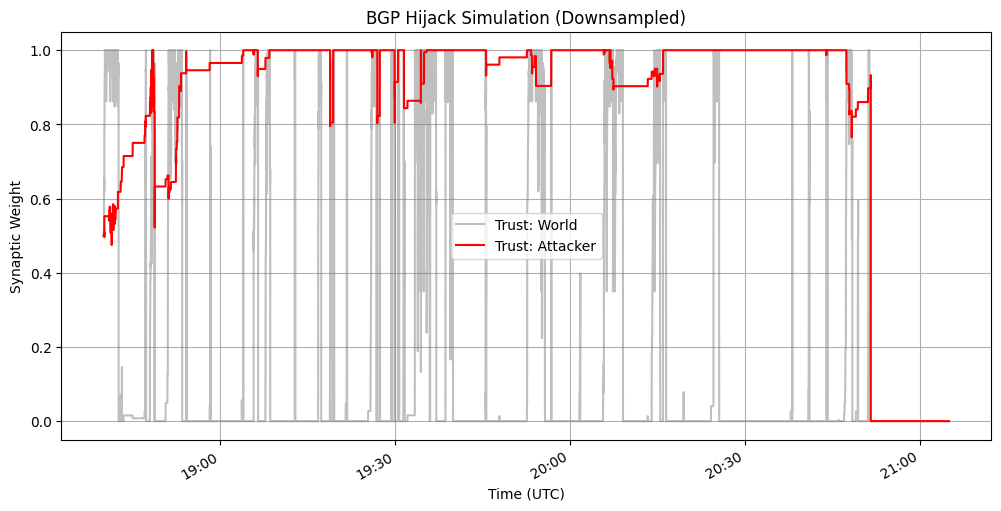

In [7]:
# --- OPTIMIZED PLOTTING (Downsampling) ---

# 1. Define a "Skip" interval
# If dt=0.1ms, skipping 10,000 steps means we plot 1 point per second.
# This reduces 84,000,000 points -> 8,400 points (Instant plot).
skip = 10

print("Downsampling data for plot...")

# 2. Slice the arrays [start:stop:step]
raw_times = w_mon.t[::skip]
weights_world = w_mon.w[0][::skip]
weights_attacker = w_mon.w[1][::skip]

# 3. Convert ONLY the downsampled times to UTC
# This runs thousands of loops instead of millions
utc_times = [global_t0 + timedelta(seconds=float(t)) for t in raw_times]

print("Plotting...")

plt.figure(figsize=(12, 6))
plt.plot(utc_times, weights_world, label='Trust: World', color='grey', alpha=0.5)
plt.plot(utc_times, weights_attacker, label='Trust: Attacker', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time (UTC)')
plt.ylabel('Synaptic Weight')
plt.title("BGP Hijack Simulation (Downsampled)")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
#!cp -r /home/anirban /content/drive/MyDrive/ColabHomeBackup/PyBGPColab/

In [ ]:
import os, sys
# os.environ['PYTHONPATH'] += ":/content/drive/MyDrive/ColabHomeBackup/PyBGPColab/anirban"
# If your library is directly in the new_home folder:
# sys.path.append("/content/drive/MyDrive/ColabHomeBackup/PyBGPColab/anirban")